In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from torchvision.datasets import ImageFolder
import numpy as np

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# To check if GPU is available
print(torch.cuda.is_available())
# To check the CUDA version
print(torch.version.cuda)

True
12.6


In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset

class GalaxyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        # Extract the class label correctly (get the part before '.png' or any extension)
        label_str = img_name.split('_')[-1].split('.')[0]
        try:
            label = int(label_str)
        except ValueError:
            print(f"Error converting label: {label_str}")
            raise
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# **Correcting the path to dataset**
data_dir = os.path.expanduser("~/Desktop/BE Project/Decals_data_images")  # Ensure correct dataset pat

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation for better generalization
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

In [6]:
dataset = GalaxyDataset(root_dir=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes):
        super(GalaxyCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Vision Transformer
        self.transformer_layer = TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = TransformerEncoder(self.transformer_layer, num_layers=6)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)

        # Transforming the feature map to the appropriate input shape for Transformer
        x = x.view(x.size(0), -1, 512)  # [batch_size, seq_length, d_model]
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the Transformer output
        
        x = self.classifier(x)
        return x


In [8]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_loss = None
    
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.counter = 0

In [9]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = val_loss / len(loader)
    print(f'Accuracy: {accuracy:.2f}%')
    return avg_loss  # Return loss for scheduler and early stopping

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs):
    model.train()
    warmup_epochs = 2
    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.0001 * (epoch + 1) / warmup_epochs
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        model.train()
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': running_loss/len(train_loader),
                'accuracy': 100.*correct/total,
                'lr': optimizer.param_groups[0]['lr']
            })
        
        # Calculate training metrics
        train_loss = running_loss/len(train_loader)
        train_acc = 100.*correct/total
        
        # Validation phase
        val_loss = evaluate_model(model, val_loader)  # Using our evaluate_model function
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}')
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        early_stopping(val_loss, model)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return history

In [10]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyCNN(num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=0.0001,
    weight_decay=1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=7,
    verbose=True,
    min_lr=1e-6
)

early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.001)
num_epochs = 20

# Train and evaluate
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs)

# Load best model and perform final evaluation
model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded successfully!")
final_accuracy = evaluate_model(model, test_loader)

c:\Users\Aseem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
c:\Users\Aseem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Evaluating: 100%|██████████| 89/89 [00:21<00:00,  4.22it/s]


Accuracy: 31.22%

Epoch 1/20:
Train Loss: 2.1500 | Train Acc: 18.87%
Val Loss: 1.8378


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.10it/s]


Accuracy: 49.33%

Epoch 2/20:
Train Loss: 1.5960 | Train Acc: 42.08%
Val Loss: 1.4179


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.18it/s]


Accuracy: 53.03%

Epoch 3/20:
Train Loss: 1.3304 | Train Acc: 52.88%
Val Loss: 1.2819


Evaluating: 100%|██████████| 89/89 [00:23<00:00,  3.79it/s]


Accuracy: 56.10%

Epoch 4/20:
Train Loss: 1.2036 | Train Acc: 56.63%
Val Loss: 1.1995


Evaluating: 100%|██████████| 89/89 [00:23<00:00,  3.82it/s]


Accuracy: 58.63%

Epoch 5/20:
Train Loss: 1.1068 | Train Acc: 60.99%
Val Loss: 1.1644


Evaluating: 100%|██████████| 89/89 [00:24<00:00,  3.63it/s]


Accuracy: 62.19%

Epoch 6/20:
Train Loss: 1.0520 | Train Acc: 62.76%
Val Loss: 1.0890


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.16it/s]


Accuracy: 63.57%

Epoch 7/20:
Train Loss: 1.0142 | Train Acc: 63.67%
Val Loss: 1.0165


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.11it/s]


Accuracy: 63.99%

Epoch 8/20:
Train Loss: 0.9622 | Train Acc: 65.37%
Val Loss: 1.0237
EarlyStopping counter: 1 out of 15


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.19it/s]


Accuracy: 63.46%

Epoch 9/20:
Train Loss: 0.9267 | Train Acc: 67.06%
Val Loss: 1.0273
EarlyStopping counter: 2 out of 15


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.15it/s]


Accuracy: 65.68%

Epoch 10/20:
Train Loss: 0.8943 | Train Acc: 68.41%
Val Loss: 0.9778


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.11it/s]


Accuracy: 64.52%

Epoch 11/20:
Train Loss: 0.8643 | Train Acc: 69.38%
Val Loss: 0.9574


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.13it/s]


Accuracy: 64.24%

Epoch 12/20:
Train Loss: 0.8395 | Train Acc: 69.78%
Val Loss: 1.0132
EarlyStopping counter: 1 out of 15


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.13it/s]


Accuracy: 66.03%

Epoch 13/20:
Train Loss: 0.8150 | Train Acc: 71.09%
Val Loss: 0.9690
EarlyStopping counter: 2 out of 15


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.16it/s]


Accuracy: 67.16%

Epoch 14/20:
Train Loss: 0.7965 | Train Acc: 71.66%
Val Loss: 0.9582
EarlyStopping counter: 3 out of 15


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.15it/s]


Accuracy: 66.84%

Epoch 15/20:
Train Loss: 0.7790 | Train Acc: 72.08%
Val Loss: 0.9535


Evaluating: 100%|██████████| 89/89 [00:17<00:00,  5.09it/s]


Accuracy: 66.63%

Epoch 16/20:
Train Loss: 0.7456 | Train Acc: 73.03%
Val Loss: 0.9790
EarlyStopping counter: 1 out of 15


Evaluating: 100%|██████████| 89/89 [00:22<00:00,  3.99it/s]


Accuracy: 67.51%

Epoch 17/20:
Train Loss: 0.7319 | Train Acc: 73.62%
Val Loss: 0.9591
EarlyStopping counter: 2 out of 15


Evaluating: 100%|██████████| 89/89 [00:24<00:00,  3.62it/s]


Accuracy: 68.60%

Epoch 18/20:
Train Loss: 0.7116 | Train Acc: 74.60%
Val Loss: 0.9169


Evaluating: 100%|██████████| 89/89 [00:24<00:00,  3.66it/s]


Accuracy: 67.34%

Epoch 19/20:
Train Loss: 0.6969 | Train Acc: 74.77%
Val Loss: 0.9704
EarlyStopping counter: 1 out of 15


Evaluating: 100%|██████████| 89/89 [00:18<00:00,  4.74it/s]


Accuracy: 68.32%

Epoch 20/20:
Train Loss: 0.6822 | Train Acc: 75.81%
Val Loss: 0.9454
EarlyStopping counter: 2 out of 15
Best model loaded successfully!


Evaluating: 100%|██████████| 111/111 [00:26<00:00,  4.25it/s]

Accuracy: 68.52%


In [11]:
# Print the structure of the history object
print(history)


{'train_loss': [2.1500469704748877, 1.5959616889416333, 1.330414626967739, 1.20361953503649, 1.1068328276486463, 1.0519519023492303, 1.0142328949881272, 0.9621709949533704, 0.9266717124153191, 0.894289328850491, 0.8643431898573755, 0.839531848632114, 0.8150002596244006, 0.7964786865341831, 0.7789937244334691, 0.7456064344291956, 0.7319456874484748, 0.711609153092747, 0.6968729493483691, 0.6821759554701792], 'train_acc': [18.87224669603524, 42.07929515418502, 52.881057268722465, 56.63436123348018, 60.986784140969164, 62.757709251101325, 63.67400881057269, 65.37444933920705, 67.05726872246696, 68.40528634361233, 69.38325991189427, 69.77973568281938, 71.09251101321586, 71.65638766519824, 72.07929515418502, 73.03083700440529, 73.62114537444934, 74.59911894273128, 74.76651982378854, 75.80616740088105], 'val_loss': [1.8378031334180511, 1.4179012594598064, 1.2819075892480571, 1.199539822808812, 1.1643846450227031, 1.0889557278558109, 1.016457413689474, 1.023653513260102, 1.0273154672611966, 0

Testing: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]

Precision: 0.6758
Recall: 0.6860
Confusion Matrix:
[[ 19  10  20  22   7  14  15  77   7   2]
 [  4 263  17   5   2   9   4  21   4   9]
 [  0   8 496   0   0   2  30   7   0   0]
 [  5  12   6 350   1  11   7  18   0   4]
 [  0   2   0  11  47   3   0   2   1   5]
 [  1  11  14   6   5 198  94  82   4   5]
 [  1  10  13   6   2  33 209  65   4   2]
 [ 13  14  14  34   7  84  80 293  11   9]
 [  4   7   1   0   4   0   2   2 243  26]
 [  1  10   1  18   7   5   1   5  12 316]]


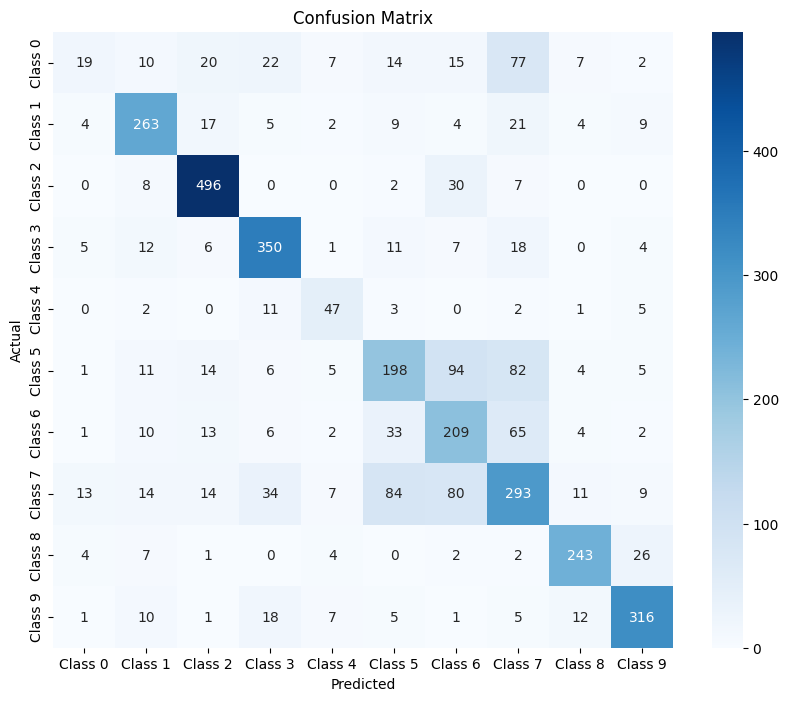

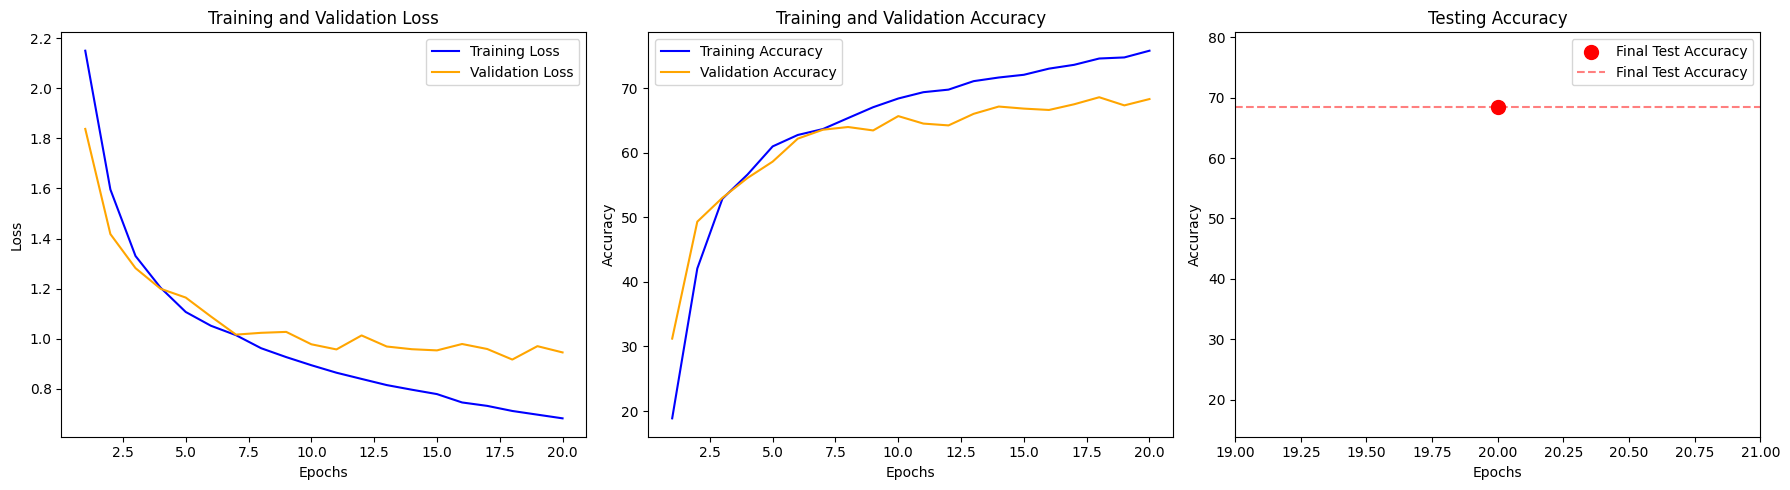

In [13]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate model on the test set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate precision, recall, and confusion matrix
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Auto-detect number of classes (handles non-sequential labels)
unique_labels = sorted(set(all_labels))  # Get sorted unique labels
class_names = [f'Class {label}' for label in unique_labels]  # Adjust dynamically

# Call the plotting function
plot_confusion_matrix(conf_matrix, class_names)

# Ensure val_acc exists in history
if 'val_acc' not in history:
    history['val_acc'] = []  # Initialize empty list

# Update the history dictionary with the validation accuracy values from the log
history['val_acc'] = [
    31.22,  # Epoch 1
    49.33,  # Epoch 2
    53.03,  # Epoch 3
    56.10,  # Epoch 4
    58.63,  # Epoch 5
    62.19,  # Epoch 6
    63.57,  # Epoch 7
    63.99,  # Epoch 8
    63.46,  # Epoch 9
    65.68,  # Epoch 10
    64.52,  # Epoch 11
    64.24,  # Epoch 12
    66.03,  # Epoch 13
    67.16,  # Epoch 14
    66.84,  # Epoch 15
    66.63,  # Epoch 16
    67.51,  # Epoch 17
    68.60,  # Epoch 18
    67.34,  # Epoch 19
    68.32   # Epoch 20
]

# Plot training history including testing accuracy
def plot_training_history(history, test_acc=68.52):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot testing accuracy
    plt.subplot(1, 3, 3)
    plt.scatter([epochs[-1]], [test_acc], color='red', label='Final Test Accuracy', marker='o', s=100)
    plt.axhline(y=test_acc, color='red', linestyle='dashed', alpha=0.5, label='Final Test Accuracy')
    plt.xlim(epochs[-1] - 1, epochs[-1] + 1)  # Keep x-axis focused on last epoch
    plt.ylim(min(history['train_acc']) - 5, max(history['train_acc']) + 5)  # Adjust y-axis to fit
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` contains training and validation loss/accuracy data 
plot_training_history(history)
